###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor



In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
400,Chile,2018,6.436,10.130,0.890,69.85,0.789,-0.068,0.816,0.755,0.276
987,Israel,2022,7.662,10.698,0.954,72.85,0.775,-0.007,0.655,0.583,0.183
210,Bhutan,2015,5.082,9.198,0.848,62.60,0.830,0.273,0.634,0.723,0.312
2259,Uruguay,2022,6.671,10.103,0.905,67.50,0.878,-0.055,0.631,0.775,0.267
161,Belarus,2007,5.617,9.576,0.858,60.62,0.667,-0.230,0.695,0.502,0.235


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_19164\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


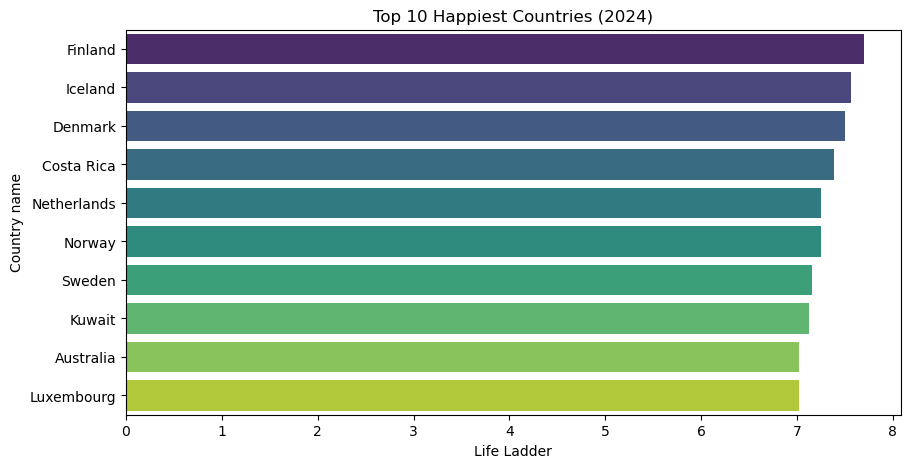

C:\Users\Sohin\AppData\Local\Temp\ipykernel_19164\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


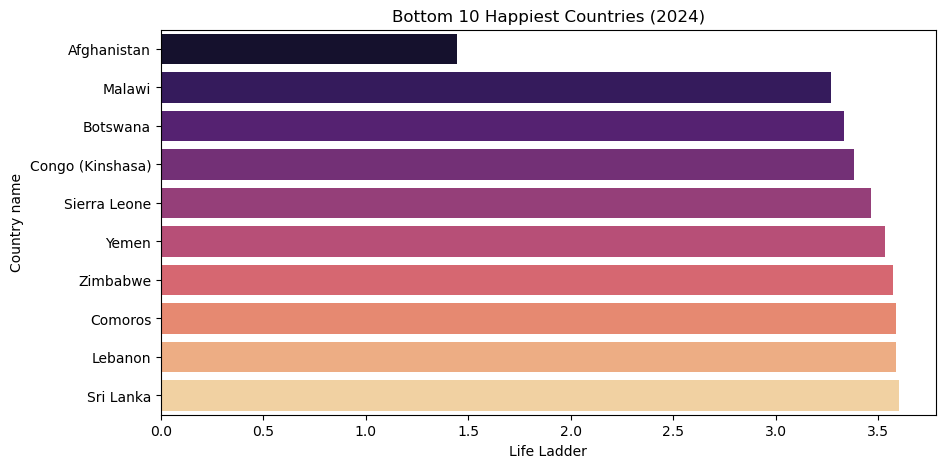

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


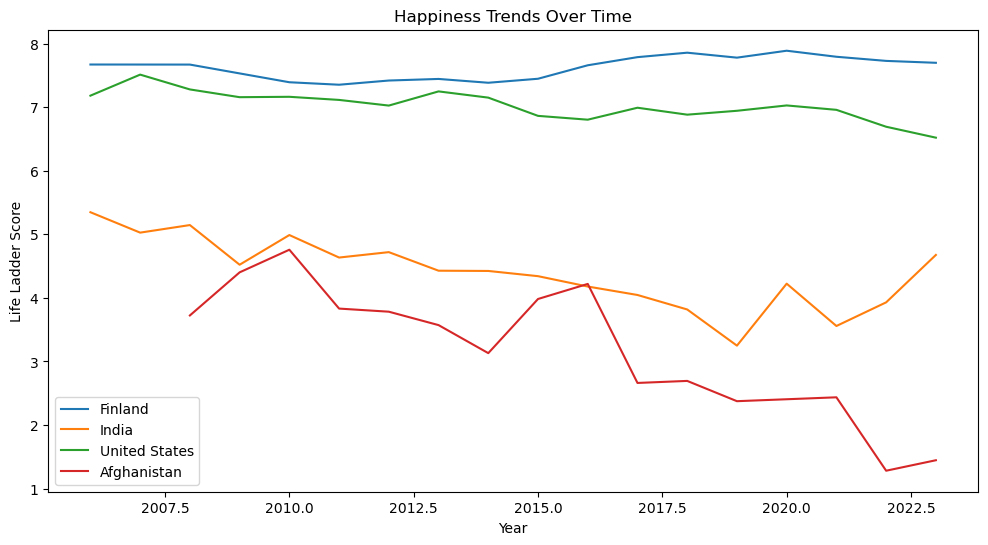

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


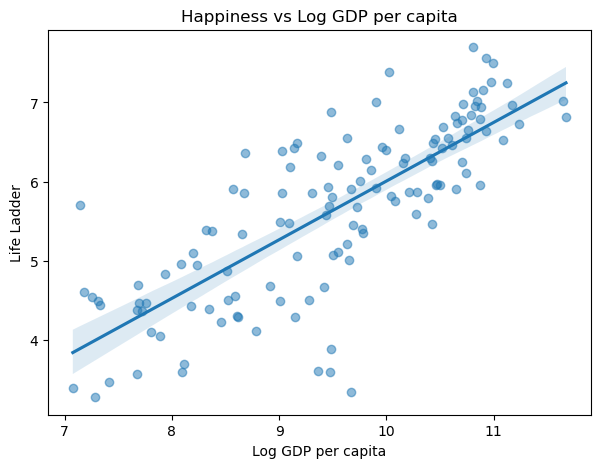

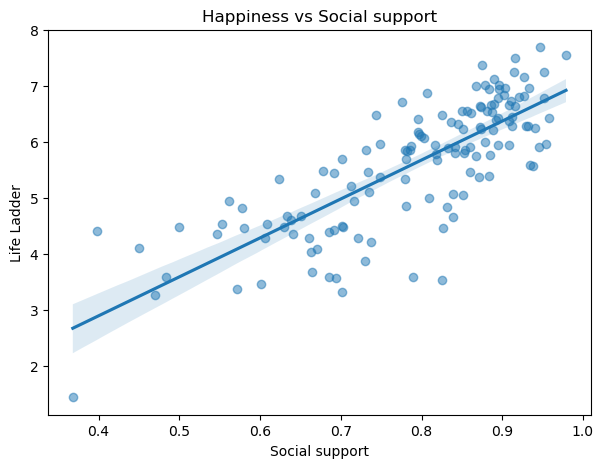

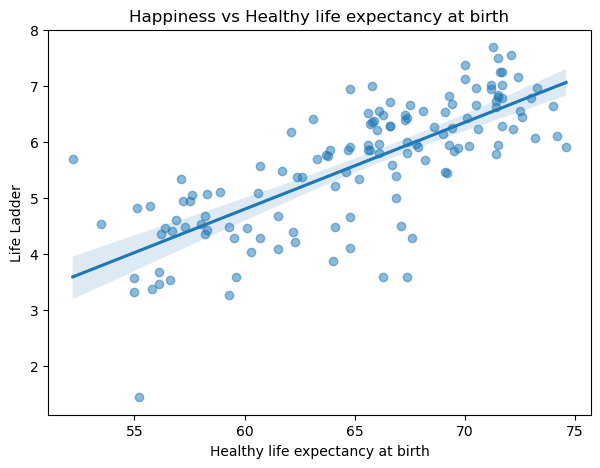

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


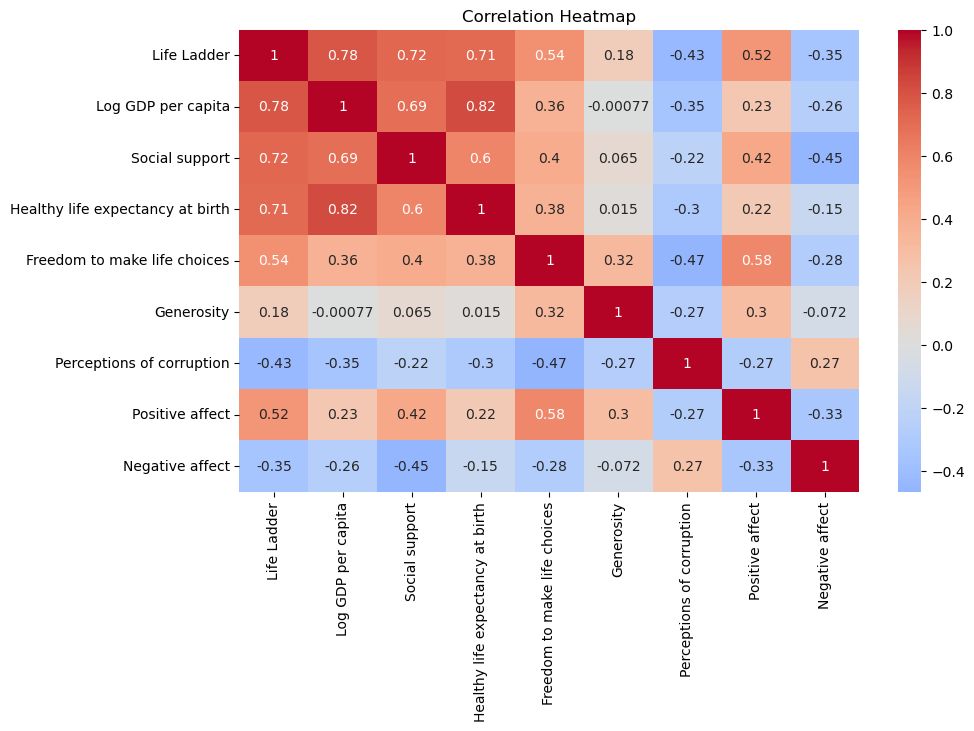

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


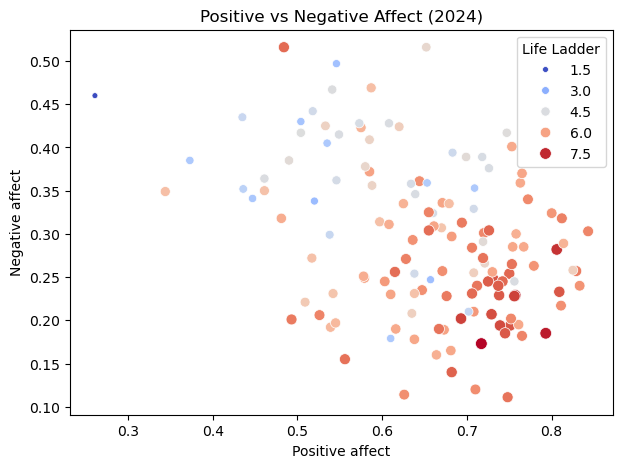

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1725 non-null   int64  
 1   Life Ladder                       1725 non-null   float64
 2   Log GDP per capita                1725 non-null   float64
 3   Social support                    1725 non-null   float64
 4   Healthy life expectancy at birth  1725 non-null   float64
 5   Freedom to make life choices      1725 non-null   float64
 6   Generosity                        1725 non-null   float64
 7   Perceptions of corruption         1725 non-null   float64
 8   Positive affect                   1725 non-null   float64
 9   Negative affect                   1725 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 148.2 KB


In [26]:

features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [27]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3947212943765264

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [ ]:
## Optuna with XGboostRF Regressor model 
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-01 10:26:27,574] A new study created in memory with name: no-name-e243ad75-760c-45fb-99d9-bf399cae4e36
[I 2025-10-01 10:26:27,933] Trial 0 finished with value: 0.3483004599109529 and parameters: {'n_estimators': 130, 'max_depth': 9}. Best is trial 0 with value: 0.3483004599109529.
[I 2025-10-01 10:26:27,969] Trial 1 finished with value: 0.3582875108264742 and parameters: {'n_estimators': 10, 'max_depth': 9}. Best is trial 0 with value: 0.3483004599109529.
[I 2025-10-01 10:26:28,164] Trial 2 finished with value: 0.35796660206052994 and parameters: {'n_estimators': 130, 'max_depth': 8}. Best is trial 0 with value: 0.3483004599109529.
[I 2025-10-01 10:26:28,269] Trial 3 finished with value: 0.3487846778839354 and parameters: {'n_estimators': 30, 'max_depth': 10}. Best is trial 0 with value: 0.3483004599109529.
[I 2025-10-01 10:26:28,415] Trial 4 finished with value: 0.3488056588551355 and parameters: {'n_estimators': 20, 'max_depth': 12}. Best is trial 0 with value: 0.348300459

In [30]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 80, 'max_depth': 15}
At trial:  11
Mean absolute error:  0.329967338259258

Hyperparameter importances:


{'max_depth': 0.9235729906224022, 'n_estimators': 0.07642700937759773}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [ ]:
## Optuna with LGBM Regressor
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model1 = LGBMRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model1

def objective(trial):
    model1 = define_model(trial)
    model1.fit(features_train, target_train)
    target_pred = model1.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-01 10:26:48,073] A new study created in memory with name: no-name-62018127-db27-46d3-a13e-6fd8b383c3ea
c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:48,201] Trial 0 finished with value: 0.31922553218581895 and parameters: {'n_estimators': 190, 'max_depth': 11}. Best is trial 0 with value: 0.31922553218581895.
[I 2025-10-01 10:26:48,257] Trial 1 finished with value: 0.3239508953152998 and parameters: {'n_estimators': 80, 'max_depth': 14}. Best is trial 0 with value: 0.31922553218581895.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:48,305] Trial 2 finished with value: 0.32873809713789076 and parameters: {'n_estimators': 70, 'max_depth': 11}. Best is trial 0 with value: 0.31922553218581895.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:48,357] Trial 3 finished with value: 0.32442712668652013 and parameters: {'n_estimators': 90, 'max_depth': 9}. Best is trial 0 with value: 0.31922553218581895.
[I 2025-10-01 10:26:48,401] Trial 4 finished with value: 0.3357120364781027 and parameters: {'n_estimators': 50, 'max_depth': 9}. Best is trial 0 with value: 0.31922553218581895.
[I 2025-10-01 10:26:48,439] Trial 5 pruned. 
[I 2025-10-01 10:26:48,455] Trial 6 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_co

[I 2025-10-01 10:26:48,516] Trial 7 finished with value: 0.32364475649044716 and parameters: {'n_estimators': 90, 'max_depth': 13}. Best is trial 0 with value: 0.31922553218581895.
[I 2025-10-01 10:26:48,565] Trial 8 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-01 10:26:48,676] Trial 9 finished with value: 0.31922553218581895 and parameters: {'n_estimators': 190, 'max_depth': 11}. Best is trial 0 with value: 0.31922553218581895.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:48,767] Trial 10 pruned. 
[I 2025-10-01 10:26:48,883] Trial 11 finished with value: 0.3211274656536293 and parameters: {'n_estimators': 190, 'max_depth': 15}. Best is trial 0 with value: 0.31922553218581895.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:48,979] Trial 12 finished with value: 0.32007709270549733 and parameters: {'n_estimators': 150, 'max_depth': 11}. Best is trial 0 with value: 0.31922553218581895.
[I 2025-10-01 10:26:49,049] Trial 13 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:49,171] Trial 14 finished with value: 0.3224768347485507 and parameters: {'n_estimators': 160, 'max_depth': 10}. Best is trial 0 with value: 0.31922553218581895.
[I 2025-10-01 10:26:49,184] Trial 15 pruned. 
[I 2025-10-01 10:26:49,262] Trial 16 finished with value: 0.32214060763924623 and parameters: {'n_estimators': 120, 'max_depth': 13}. Best is trial 0 with value: 0.31922553218581895.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:49,357] Trial 17 finished with value: 0.3220878829478341 and parameters: {'n_estimators': 180, 'max_depth': 8}. Best is trial 0 with value: 0.31922553218581895.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:49,458] Trial 18 finished with value: 0.3189510459678121 and parameters: {'n_estimators': 170, 'max_depth': 11}. Best is trial 18 with value: 0.3189510459678121.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:49,564] Trial 19 finished with value: 0.320714376638047 and parameters: {'n_estimators': 170, 'max_depth': 13}. Best is trial 18 with value: 0.3189510459678121.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:49,656] Trial 20 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training 

[I 2025-10-01 10:26:49,775] Trial 21 finished with value: 0.3192050711701455 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 18 with value: 0.3189510459678121.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:49,886] Trial 22 finished with value: 0.32090354695519857 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 18 with value: 0.3189510459678121.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:49,998] Trial 23 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:50,095] Trial 24 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:50,211] Trial 25 pruned. 
[I 2025-10-01 10:26:50,285] Trial 26 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:50,356] Trial 27 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:50,459] Trial 28 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:50,557] Trial 29 finished with value: 0.31917546767402893 and parameters: {'n_estimators': 150, 'max_depth': 14}. Best is trial 18 with value: 0.3189510459678121.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-01 10:26:50,685] Trial 30 finished with value: 0.3199692886325767 and parameters: {'n_estimators': 140, 'max_depth': 14}. Best is trial 18 with value: 0.3189510459678121.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 

[I 2025-10-01 10:26:50,787] Trial 31 finished with value: 0.3187411441769178 and parameters: {'n_estimators': 160, 'max_depth': 14}. Best is trial 31 with value: 0.3187411441769178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:50,894] Trial 32 finished with value: 0.3187411441769178 and parameters: {'n_estimators': 160, 'max_depth': 14}. Best is trial 31 with value: 0.3187411441769178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 10:26:50,993] Trial 33 finished with value: 0.31917546767402893 and parameters: {'n_estimators': 150, 'max_depth': 14}. Best is trial 31 with value: 0.3187411441769178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:51,070] Trial 34 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:51,179] Trial 35 finished with value: 0.3187411441769178 and parameters: {'n_estimators': 160, 'max_depth': 14}. Best is trial 31 with value: 0.3187411441769178.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:51,294] Trial 36 pruned. 
[I 2025-10-01 10:26:51,377] Trial 37 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 10:26:51,452] Trial 38 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used 

[I 2025-10-01 10:26:51,553] Trial 39 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [32]:
print('Best LGBM parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances

Best LGBM parameters:  {'n_estimators': 160, 'max_depth': 14}
At trial:  31
Mean absolute error:  0.3187411441769178

Hyperparameter importances:


{'n_estimators': 0.93634176173892, 'max_depth': 0.06365823826107996}

So, for this data, we know the following about Light GBM: the best hyperparameters we could find with 200 estimators and max depth of 14; we were able to achieve a MAE of 0.316; and the  n_estimators parameter had a way bigger effect on the outcome  than the max_depth parameter did.

In [ ]:
## Optuna with Catboost Regressor
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-01 10:26:53,143] A new study created in memory with name: no-name-ad4b00b4-7ee1-4c78-b899-3a2c3b88043f


Learning rate set to 0.29013
0:	learn: 0.8998399	total: 2.92ms	remaining: 289ms
1:	learn: 0.7432987	total: 5.59ms	remaining: 274ms
2:	learn: 0.6420565	total: 8.23ms	remaining: 266ms
3:	learn: 0.5714153	total: 10.9ms	remaining: 261ms
4:	learn: 0.5223033	total: 13.2ms	remaining: 251ms
5:	learn: 0.4894432	total: 15.7ms	remaining: 246ms
6:	learn: 0.4634642	total: 18.1ms	remaining: 241ms
7:	learn: 0.4484685	total: 20.6ms	remaining: 236ms
8:	learn: 0.4339874	total: 23.3ms	remaining: 235ms
9:	learn: 0.4234504	total: 26.4ms	remaining: 238ms
10:	learn: 0.4153820	total: 29.1ms	remaining: 236ms
11:	learn: 0.4085558	total: 31.8ms	remaining: 233ms
12:	learn: 0.4011289	total: 34.3ms	remaining: 230ms
13:	learn: 0.3954515	total: 36.8ms	remaining: 226ms
14:	learn: 0.3909436	total: 39.6ms	remaining: 224ms
15:	learn: 0.3858139	total: 42.2ms	remaining: 221ms
16:	learn: 0.3813447	total: 44.7ms	remaining: 218ms
17:	learn: 0.3771462	total: 47.4ms	remaining: 216ms
18:	learn: 0.3739679	total: 50ms	remaining: 2

[I 2025-10-01 10:26:53,479] Trial 0 finished with value: 0.3554648090444235 and parameters: {'n_estimators': 100, 'max_depth': 8}. Best is trial 0 with value: 0.3554648090444235.


71:	learn: 0.1957700	total: 193ms	remaining: 75.2ms
72:	learn: 0.1938332	total: 196ms	remaining: 72.6ms
73:	learn: 0.1911965	total: 199ms	remaining: 69.9ms
74:	learn: 0.1889886	total: 201ms	remaining: 67.2ms
75:	learn: 0.1879951	total: 204ms	remaining: 64.4ms
76:	learn: 0.1861669	total: 207ms	remaining: 61.9ms
77:	learn: 0.1847079	total: 210ms	remaining: 59.1ms
78:	learn: 0.1841999	total: 213ms	remaining: 56.5ms
79:	learn: 0.1808861	total: 215ms	remaining: 53.8ms
80:	learn: 0.1794557	total: 218ms	remaining: 51.1ms
81:	learn: 0.1779399	total: 221ms	remaining: 48.4ms
82:	learn: 0.1763555	total: 223ms	remaining: 45.8ms
83:	learn: 0.1742320	total: 226ms	remaining: 43.1ms
84:	learn: 0.1720491	total: 229ms	remaining: 40.4ms
85:	learn: 0.1692286	total: 232ms	remaining: 37.7ms
86:	learn: 0.1683661	total: 234ms	remaining: 35ms
87:	learn: 0.1661953	total: 237ms	remaining: 32.3ms
88:	learn: 0.1642229	total: 240ms	remaining: 29.6ms
89:	learn: 0.1614339	total: 243ms	remaining: 26.9ms
90:	learn: 0.1

[I 2025-10-01 10:26:53,646] Trial 1 finished with value: 0.330003663267864 and parameters: {'n_estimators': 140, 'max_depth': 5}. Best is trial 1 with value: 0.330003663267864.
[I 2025-10-01 10:26:53,713] Trial 2 finished with value: 0.36395013216594624 and parameters: {'n_estimators': 60, 'max_depth': 2}. Best is trial 1 with value: 0.330003663267864.


86:	learn: 0.3108599	total: 73.2ms	remaining: 44.6ms
87:	learn: 0.3097536	total: 74ms	remaining: 43.8ms
88:	learn: 0.3091444	total: 74.8ms	remaining: 42.9ms
89:	learn: 0.3065497	total: 75.7ms	remaining: 42ms
90:	learn: 0.3062301	total: 76.3ms	remaining: 41.1ms
91:	learn: 0.3048200	total: 77.1ms	remaining: 40.2ms
92:	learn: 0.3035043	total: 77.8ms	remaining: 39.3ms
93:	learn: 0.3031166	total: 78.5ms	remaining: 38.4ms
94:	learn: 0.3025954	total: 79.4ms	remaining: 37.6ms
95:	learn: 0.3012935	total: 80.3ms	remaining: 36.8ms
96:	learn: 0.3002728	total: 81.1ms	remaining: 36ms
97:	learn: 0.2993703	total: 81.9ms	remaining: 35.1ms
98:	learn: 0.2970990	total: 82.7ms	remaining: 34.2ms
99:	learn: 0.2960171	total: 83.4ms	remaining: 33.4ms
100:	learn: 0.2950817	total: 84.2ms	remaining: 32.5ms
101:	learn: 0.2929856	total: 84.9ms	remaining: 31.6ms
102:	learn: 0.2920246	total: 85.7ms	remaining: 30.8ms
103:	learn: 0.2909790	total: 86.4ms	remaining: 29.9ms
104:	learn: 0.2895782	total: 87.4ms	remaining: 2

[I 2025-10-01 10:27:00,071] Trial 3 finished with value: 0.33322019539843106 and parameters: {'n_estimators': 180, 'max_depth': 12}. Best is trial 1 with value: 0.330003663267864.
[I 2025-10-01 10:27:00,178] Trial 4 finished with value: 0.3558339378104554 and parameters: {'n_estimators': 150, 'max_depth': 2}. Best is trial 1 with value: 0.330003663267864.


179:	learn: 0.0416758	total: 6.21s	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9924606	total: 612us	remaining: 91.2ms
1:	learn: 0.8788937	total: 1.16ms	remaining: 85.8ms
2:	learn: 0.8000755	total: 1.59ms	remaining: 77.8ms
3:	learn: 0.7352284	total: 1.98ms	remaining: 72.4ms
4:	learn: 0.6828014	total: 2.4ms	remaining: 69.7ms
5:	learn: 0.6473053	total: 2.79ms	remaining: 67ms
6:	learn: 0.6134754	total: 3.17ms	remaining: 64.7ms
7:	learn: 0.5891006	total: 3.56ms	remaining: 63.1ms
8:	learn: 0.5697855	total: 3.93ms	remaining: 61.6ms
9:	learn: 0.5559016	total: 4.29ms	remaining: 60.1ms
10:	learn: 0.5440332	total: 4.65ms	remaining: 58.7ms
11:	learn: 0.5377928	total: 5ms	remaining: 57.6ms
12:	learn: 0.5294964	total: 5.34ms	remaining: 56.3ms
13:	learn: 0.5210815	total: 5.82ms	remaining: 56.5ms
14:	learn: 0.5153357	total: 6.2ms	remaining: 55.8ms
15:	learn: 0.5108883	total: 6.56ms	remaining: 54.9ms
16:	learn: 0.5054619	total: 6.89ms	remaining: 53.9ms
17:	learn: 0.5027184	total: 7.28ms	re

[I 2025-10-01 10:27:43,129] Trial 5 pruned. 


Learning rate set to 0.5
0:	learn: 0.7885794	total: 72ms	remaining: 2.09s
1:	learn: 0.5984781	total: 144ms	remaining: 2.02s
2:	learn: 0.4845658	total: 217ms	remaining: 1.95s
3:	learn: 0.4154877	total: 289ms	remaining: 1.88s
4:	learn: 0.3783091	total: 360ms	remaining: 1.8s
5:	learn: 0.3472244	total: 431ms	remaining: 1.72s
6:	learn: 0.3227907	total: 510ms	remaining: 1.68s
7:	learn: 0.3027742	total: 582ms	remaining: 1.6s
8:	learn: 0.2833387	total: 655ms	remaining: 1.53s
9:	learn: 0.2683051	total: 726ms	remaining: 1.45s
10:	learn: 0.2568579	total: 798ms	remaining: 1.38s
11:	learn: 0.2452330	total: 870ms	remaining: 1.3s
12:	learn: 0.2347369	total: 940ms	remaining: 1.23s
13:	learn: 0.2220674	total: 1.01s	remaining: 1.16s
14:	learn: 0.2109944	total: 1.08s	remaining: 1.08s
15:	learn: 0.2012227	total: 1.16s	remaining: 1.01s
16:	learn: 0.1934117	total: 1.23s	remaining: 938ms
17:	learn: 0.1858462	total: 1.3s	remaining: 864ms
18:	learn: 0.1788289	total: 1.37s	remaining: 792ms
19:	learn: 0.1712817	

[I 2025-10-01 10:27:45,358] Trial 6 pruned. 


29:	learn: 0.1172195	total: 2.15s	remaining: 0us
Learning rate set to 0.17991
0:	learn: 0.9825505	total: 2.16ms	remaining: 386ms
1:	learn: 0.8738050	total: 3.85ms	remaining: 343ms
2:	learn: 0.7808638	total: 5.61ms	remaining: 331ms
3:	learn: 0.7058407	total: 7.47ms	remaining: 329ms
4:	learn: 0.6501338	total: 9.48ms	remaining: 332ms
5:	learn: 0.6030301	total: 11.3ms	remaining: 329ms
6:	learn: 0.5673190	total: 13.1ms	remaining: 323ms
7:	learn: 0.5391459	total: 14.6ms	remaining: 314ms
8:	learn: 0.5179547	total: 16.2ms	remaining: 308ms
9:	learn: 0.5007465	total: 17.9ms	remaining: 304ms
10:	learn: 0.4860978	total: 19.5ms	remaining: 299ms
11:	learn: 0.4744503	total: 21.3ms	remaining: 298ms
12:	learn: 0.4636698	total: 23.2ms	remaining: 298ms
13:	learn: 0.4549781	total: 25ms	remaining: 297ms
14:	learn: 0.4453922	total: 26.9ms	remaining: 296ms
15:	learn: 0.4384221	total: 28.8ms	remaining: 295ms
16:	learn: 0.4336045	total: 30.7ms	remaining: 294ms
17:	learn: 0.4296741	total: 32.7ms	remaining: 294m

[I 2025-10-01 10:27:45,734] Trial 7 finished with value: 0.32772613683811336 and parameters: {'n_estimators': 180, 'max_depth': 7}. Best is trial 7 with value: 0.32772613683811336.


86:	learn: 0.2666063	total: 156ms	remaining: 167ms
87:	learn: 0.2636344	total: 158ms	remaining: 165ms
88:	learn: 0.2618255	total: 160ms	remaining: 163ms
89:	learn: 0.2606627	total: 161ms	remaining: 161ms
90:	learn: 0.2600434	total: 163ms	remaining: 160ms
91:	learn: 0.2576626	total: 165ms	remaining: 158ms
92:	learn: 0.2552801	total: 167ms	remaining: 156ms
93:	learn: 0.2532745	total: 168ms	remaining: 154ms
94:	learn: 0.2515210	total: 170ms	remaining: 152ms
95:	learn: 0.2501316	total: 172ms	remaining: 151ms
96:	learn: 0.2472161	total: 174ms	remaining: 149ms
97:	learn: 0.2462489	total: 176ms	remaining: 147ms
98:	learn: 0.2449769	total: 177ms	remaining: 145ms
99:	learn: 0.2437814	total: 179ms	remaining: 143ms
100:	learn: 0.2429437	total: 181ms	remaining: 141ms
101:	learn: 0.2406032	total: 183ms	remaining: 140ms
102:	learn: 0.2391657	total: 184ms	remaining: 138ms
103:	learn: 0.2373778	total: 186ms	remaining: 136ms
104:	learn: 0.2353241	total: 188ms	remaining: 134ms
105:	learn: 0.2346506	tota

[I 2025-10-01 10:27:46,525] Trial 8 pruned. 


18:	learn: 0.2039207	total: 701ms	remaining: 36.9ms
19:	learn: 0.1980075	total: 738ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7539752	total: 5.37ms	remaining: 156ms
1:	learn: 0.5801976	total: 10.3ms	remaining: 144ms
2:	learn: 0.5025427	total: 14.9ms	remaining: 134ms
3:	learn: 0.4609516	total: 19.6ms	remaining: 127ms
4:	learn: 0.4339777	total: 24.3ms	remaining: 121ms
5:	learn: 0.4053357	total: 29.5ms	remaining: 118ms
6:	learn: 0.3836770	total: 34.6ms	remaining: 114ms
7:	learn: 0.3773928	total: 40ms	remaining: 110ms
8:	learn: 0.3709584	total: 45.6ms	remaining: 106ms
9:	learn: 0.3567523	total: 50.8ms	remaining: 102ms
10:	learn: 0.3443952	total: 55.7ms	remaining: 96.2ms
11:	learn: 0.3354453	total: 61.5ms	remaining: 92.3ms
12:	learn: 0.3261805	total: 67.5ms	remaining: 88.3ms
13:	learn: 0.3194741	total: 72.2ms	remaining: 82.5ms
14:	learn: 0.3125515	total: 77.3ms	remaining: 77.3ms
15:	learn: 0.3075292	total: 82.5ms	remaining: 72.2ms
16:	learn: 0.2982147	total: 87.4ms	remaining: 66

[I 2025-10-01 10:27:46,729] Trial 9 pruned. 


24:	learn: 0.2373491	total: 128ms	remaining: 25.7ms
25:	learn: 0.2317903	total: 133ms	remaining: 20.5ms
26:	learn: 0.2273218	total: 138ms	remaining: 15.4ms
27:	learn: 0.2214813	total: 144ms	remaining: 10.3ms
28:	learn: 0.2172852	total: 149ms	remaining: 5.13ms
29:	learn: 0.2131249	total: 154ms	remaining: 0us
Learning rate set to 0.172173
0:	learn: 0.9911941	total: 1.75ms	remaining: 330ms
1:	learn: 0.8809050	total: 2.94ms	remaining: 276ms
2:	learn: 0.7886568	total: 4.09ms	remaining: 255ms
3:	learn: 0.7185563	total: 5.36ms	remaining: 249ms
4:	learn: 0.6648462	total: 6.57ms	remaining: 243ms
5:	learn: 0.6197063	total: 7.79ms	remaining: 239ms
6:	learn: 0.5838768	total: 8.94ms	remaining: 234ms
7:	learn: 0.5566749	total: 10.1ms	remaining: 230ms
8:	learn: 0.5333429	total: 11.2ms	remaining: 225ms
9:	learn: 0.5131805	total: 12.3ms	remaining: 221ms
10:	learn: 0.5002067	total: 13.4ms	remaining: 219ms
11:	learn: 0.4883897	total: 14.5ms	remaining: 215ms
12:	learn: 0.4762414	total: 15.6ms	remaining: 2

[I 2025-10-01 10:27:47,010] Trial 10 finished with value: 0.33691941321193175 and parameters: {'n_estimators': 190, 'max_depth': 6}. Best is trial 7 with value: 0.32772613683811336.


107:	learn: 0.2773563	total: 130ms	remaining: 98.4ms
108:	learn: 0.2765585	total: 131ms	remaining: 97.2ms
109:	learn: 0.2750233	total: 132ms	remaining: 95.9ms
110:	learn: 0.2742967	total: 133ms	remaining: 94.7ms
111:	learn: 0.2735594	total: 134ms	remaining: 93.5ms
112:	learn: 0.2720781	total: 136ms	remaining: 92.3ms
113:	learn: 0.2715368	total: 137ms	remaining: 91.1ms
114:	learn: 0.2704981	total: 138ms	remaining: 89.8ms
115:	learn: 0.2689951	total: 139ms	remaining: 88.6ms
116:	learn: 0.2680870	total: 140ms	remaining: 87.4ms
117:	learn: 0.2667343	total: 141ms	remaining: 86.2ms
118:	learn: 0.2641539	total: 143ms	remaining: 85.1ms
119:	learn: 0.2622431	total: 144ms	remaining: 83.9ms
120:	learn: 0.2608962	total: 145ms	remaining: 82.7ms
121:	learn: 0.2593819	total: 146ms	remaining: 81.5ms
122:	learn: 0.2586799	total: 147ms	remaining: 80.3ms
123:	learn: 0.2584253	total: 149ms	remaining: 79ms
124:	learn: 0.2578142	total: 150ms	remaining: 77.8ms
125:	learn: 0.2566084	total: 151ms	remaining: 76

[I 2025-10-01 10:27:47,177] Trial 11 finished with value: 0.32707173754997326 and parameters: {'n_estimators': 120, 'max_depth': 5}. Best is trial 11 with value: 0.32707173754997326.


66:	learn: 0.3233157	total: 63.3ms	remaining: 50.1ms
67:	learn: 0.3208408	total: 64.4ms	remaining: 49.3ms
68:	learn: 0.3183672	total: 65.4ms	remaining: 48.3ms
69:	learn: 0.3161828	total: 66.5ms	remaining: 47.5ms
70:	learn: 0.3146648	total: 67.3ms	remaining: 46.5ms
71:	learn: 0.3134532	total: 68.2ms	remaining: 45.5ms
72:	learn: 0.3117943	total: 69.1ms	remaining: 44.5ms
73:	learn: 0.3101683	total: 70ms	remaining: 43.5ms
74:	learn: 0.3091726	total: 70.8ms	remaining: 42.5ms
75:	learn: 0.3072511	total: 71.7ms	remaining: 41.5ms
76:	learn: 0.3056671	total: 72.6ms	remaining: 40.6ms
77:	learn: 0.3043860	total: 73.5ms	remaining: 39.6ms
78:	learn: 0.3036393	total: 74.4ms	remaining: 38.6ms
79:	learn: 0.3019857	total: 75.3ms	remaining: 37.6ms
80:	learn: 0.3008504	total: 76.3ms	remaining: 36.7ms
81:	learn: 0.2994475	total: 77.5ms	remaining: 35.9ms
82:	learn: 0.2983877	total: 78.5ms	remaining: 35ms
83:	learn: 0.2973659	total: 79.5ms	remaining: 34.1ms
84:	learn: 0.2965696	total: 80.4ms	remaining: 33.1

[I 2025-10-01 10:27:47,330] Trial 12 finished with value: 0.32707173754997326 and parameters: {'n_estimators': 120, 'max_depth': 5}. Best is trial 11 with value: 0.32707173754997326.
[I 2025-10-01 10:27:47,461] Trial 13 pruned. 


115:	learn: 0.2614371	total: 98.2ms	remaining: 3.39ms
116:	learn: 0.2602710	total: 99.4ms	remaining: 2.55ms
117:	learn: 0.2592841	total: 100ms	remaining: 1.7ms
118:	learn: 0.2586167	total: 101ms	remaining: 851us
119:	learn: 0.2582535	total: 102ms	remaining: 0us
Learning rate set to 0.268497
0:	learn: 0.9251618	total: 1.01ms	remaining: 110ms
1:	learn: 0.7862536	total: 1.67ms	remaining: 90.2ms
2:	learn: 0.6945837	total: 2.3ms	remaining: 82ms
3:	learn: 0.6222633	total: 2.94ms	remaining: 78.1ms
4:	learn: 0.5755424	total: 3.57ms	remaining: 75ms
5:	learn: 0.5475947	total: 4.2ms	remaining: 72.8ms
6:	learn: 0.5237532	total: 4.78ms	remaining: 70.4ms
7:	learn: 0.5069811	total: 5.53ms	remaining: 70.5ms
8:	learn: 0.4970310	total: 6.23ms	remaining: 70ms
9:	learn: 0.4885874	total: 6.87ms	remaining: 68.7ms
10:	learn: 0.4818859	total: 7.48ms	remaining: 67.3ms
11:	learn: 0.4765357	total: 8.06ms	remaining: 65.9ms
12:	learn: 0.4724238	total: 8.73ms	remaining: 65.2ms
13:	learn: 0.4685439	total: 9.32ms	rem

[I 2025-10-01 10:27:47,566] Trial 14 pruned. 


10:	learn: 0.4902129	total: 6.42ms	remaining: 52ms
11:	learn: 0.4860488	total: 6.92ms	remaining: 50.8ms
12:	learn: 0.4807307	total: 7.4ms	remaining: 49.5ms
13:	learn: 0.4751554	total: 7.99ms	remaining: 49.1ms
14:	learn: 0.4726734	total: 8.47ms	remaining: 48ms
15:	learn: 0.4695463	total: 9.02ms	remaining: 47.4ms
16:	learn: 0.4676221	total: 9.5ms	remaining: 46.4ms
17:	learn: 0.4654401	total: 9.97ms	remaining: 45.4ms
18:	learn: 0.4639271	total: 10.4ms	remaining: 44.4ms
19:	learn: 0.4623959	total: 11.1ms	remaining: 44.3ms
20:	learn: 0.4612429	total: 11.5ms	remaining: 43.4ms
21:	learn: 0.4596579	total: 12.1ms	remaining: 42.8ms
22:	learn: 0.4585654	total: 12.5ms	remaining: 41.9ms
23:	learn: 0.4564925	total: 12.9ms	remaining: 40.9ms
24:	learn: 0.4542371	total: 13.5ms	remaining: 40.5ms
25:	learn: 0.4532719	total: 13.9ms	remaining: 39.6ms
26:	learn: 0.4515320	total: 14.4ms	remaining: 39ms
27:	learn: 0.4494140	total: 14.9ms	remaining: 38.4ms
28:	learn: 0.4469463	total: 15.5ms	remaining: 38ms
29:

[I 2025-10-01 10:27:47,964] Trial 15 pruned. 
[I 2025-10-01 10:27:48,047] Trial 16 pruned. 


64:	learn: 0.1310690	total: 311ms	remaining: 24ms
65:	learn: 0.1290583	total: 316ms	remaining: 19.2ms
66:	learn: 0.1257671	total: 321ms	remaining: 14.4ms
67:	learn: 0.1241643	total: 326ms	remaining: 9.59ms
68:	learn: 0.1217536	total: 331ms	remaining: 4.79ms
69:	learn: 0.1206462	total: 335ms	remaining: 0us
Learning rate set to 0.25016
0:	learn: 1.0066116	total: 403us	remaining: 48ms
1:	learn: 0.9209361	total: 797us	remaining: 47ms
2:	learn: 0.8521826	total: 1.14ms	remaining: 44.6ms
3:	learn: 0.7871869	total: 1.41ms	remaining: 40.8ms
4:	learn: 0.7391348	total: 1.68ms	remaining: 38.5ms
5:	learn: 0.6988181	total: 1.93ms	remaining: 36.6ms
6:	learn: 0.6654405	total: 2.21ms	remaining: 35.6ms
7:	learn: 0.6393800	total: 2.53ms	remaining: 35.5ms
8:	learn: 0.6190587	total: 2.8ms	remaining: 34.6ms
9:	learn: 0.5968671	total: 3.1ms	remaining: 34.1ms
10:	learn: 0.5817572	total: 3.35ms	remaining: 33.2ms
11:	learn: 0.5710451	total: 3.58ms	remaining: 32.2ms
12:	learn: 0.5613474	total: 3.86ms	remaining: 

[I 2025-10-01 10:27:48,179] Trial 17 finished with value: 0.32404397689665637 and parameters: {'n_estimators': 70, 'max_depth': 6}. Best is trial 17 with value: 0.32404397689665637.


48:	learn: 0.2815560	total: 58.8ms	remaining: 25.2ms
49:	learn: 0.2778827	total: 60ms	remaining: 24ms
50:	learn: 0.2747597	total: 61.1ms	remaining: 22.8ms
51:	learn: 0.2734973	total: 62.2ms	remaining: 21.5ms
52:	learn: 0.2698197	total: 63.2ms	remaining: 20.3ms
53:	learn: 0.2676862	total: 64.3ms	remaining: 19ms
54:	learn: 0.2656609	total: 65.3ms	remaining: 17.8ms
55:	learn: 0.2627633	total: 66.4ms	remaining: 16.6ms
56:	learn: 0.2598995	total: 67.5ms	remaining: 15.4ms
57:	learn: 0.2574151	total: 68.6ms	remaining: 14.2ms
58:	learn: 0.2555485	total: 69.8ms	remaining: 13ms
59:	learn: 0.2545680	total: 71.6ms	remaining: 11.9ms
60:	learn: 0.2524383	total: 72.8ms	remaining: 10.7ms
61:	learn: 0.2509502	total: 74.3ms	remaining: 9.59ms
62:	learn: 0.2486338	total: 75.5ms	remaining: 8.38ms
63:	learn: 0.2470908	total: 76.5ms	remaining: 7.17ms
64:	learn: 0.2452478	total: 77.5ms	remaining: 5.96ms
65:	learn: 0.2435582	total: 78.5ms	remaining: 4.76ms
66:	learn: 0.2418026	total: 79.7ms	remaining: 3.57ms
6

[I 2025-10-01 10:27:48,936] Trial 18 pruned. 


54:	learn: 0.1296982	total: 544ms	remaining: 148ms
55:	learn: 0.1260978	total: 554ms	remaining: 138ms
56:	learn: 0.1234355	total: 565ms	remaining: 129ms
57:	learn: 0.1208160	total: 574ms	remaining: 119ms
58:	learn: 0.1191333	total: 584ms	remaining: 109ms
59:	learn: 0.1169039	total: 594ms	remaining: 99ms
60:	learn: 0.1152061	total: 604ms	remaining: 89.1ms
61:	learn: 0.1134467	total: 614ms	remaining: 79.2ms
62:	learn: 0.1109952	total: 623ms	remaining: 69.2ms
63:	learn: 0.1084227	total: 632ms	remaining: 59.3ms
64:	learn: 0.1072476	total: 642ms	remaining: 49.4ms
65:	learn: 0.1049119	total: 651ms	remaining: 39.5ms
66:	learn: 0.1028797	total: 662ms	remaining: 29.7ms
67:	learn: 0.1015257	total: 672ms	remaining: 19.8ms
68:	learn: 0.0999539	total: 682ms	remaining: 9.89ms
69:	learn: 0.0989472	total: 692ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7431459	total: 2.29ms	remaining: 112ms
1:	learn: 0.5757041	total: 4.09ms	remaining: 98.1ms
2:	learn: 0.5037166	total: 5.69ms	remaining: 89.2m

[I 2025-10-01 10:27:49,069] Trial 19 pruned. 


3:	learn: 0.4735817	total: 7.53ms	remaining: 86.6ms
4:	learn: 0.4540923	total: 9.53ms	remaining: 85.7ms
5:	learn: 0.4418239	total: 11.2ms	remaining: 82.3ms
6:	learn: 0.4317643	total: 12.9ms	remaining: 79.2ms
7:	learn: 0.4210117	total: 14.4ms	remaining: 75.8ms
8:	learn: 0.4133075	total: 16.1ms	remaining: 73.4ms
9:	learn: 0.4044129	total: 17.8ms	remaining: 71.2ms
10:	learn: 0.3937740	total: 19.4ms	remaining: 68.8ms
11:	learn: 0.3867714	total: 21.4ms	remaining: 67.7ms
12:	learn: 0.3799891	total: 23.2ms	remaining: 65.9ms
13:	learn: 0.3716232	total: 25.1ms	remaining: 64.6ms
14:	learn: 0.3621937	total: 26.8ms	remaining: 62.5ms
15:	learn: 0.3556014	total: 28.5ms	remaining: 60.5ms
16:	learn: 0.3482610	total: 30.1ms	remaining: 58.4ms
17:	learn: 0.3409911	total: 31.9ms	remaining: 56.7ms
18:	learn: 0.3368358	total: 33.7ms	remaining: 55ms
19:	learn: 0.3293405	total: 35.4ms	remaining: 53.1ms
20:	learn: 0.3208410	total: 37.1ms	remaining: 51.3ms
21:	learn: 0.3168683	total: 38.8ms	remaining: 49.4ms
22

[I 2025-10-01 10:27:49,195] Trial 20 pruned. 
[I 2025-10-01 10:27:49,355] Trial 21 pruned. 


Learning rate set to 0.234399
0:	learn: 0.9491301	total: 1.66ms	remaining: 214ms
1:	learn: 0.8143811	total: 2.68ms	remaining: 172ms
2:	learn: 0.7207684	total: 3.59ms	remaining: 152ms
3:	learn: 0.6424674	total: 4.65ms	remaining: 146ms
4:	learn: 0.5923734	total: 5.59ms	remaining: 140ms
5:	learn: 0.5516646	total: 6.61ms	remaining: 137ms
6:	learn: 0.5237767	total: 7.66ms	remaining: 135ms
7:	learn: 0.5044446	total: 8.42ms	remaining: 128ms
8:	learn: 0.4908528	total: 9.11ms	remaining: 122ms
9:	learn: 0.4804915	total: 9.93ms	remaining: 119ms
10:	learn: 0.4719602	total: 10.6ms	remaining: 115ms
11:	learn: 0.4658420	total: 11.3ms	remaining: 111ms
12:	learn: 0.4616797	total: 12ms	remaining: 108ms
13:	learn: 0.4575934	total: 12.7ms	remaining: 105ms
14:	learn: 0.4508589	total: 13.4ms	remaining: 103ms
15:	learn: 0.4457740	total: 14ms	remaining: 100ms
16:	learn: 0.4423891	total: 14.8ms	remaining: 98.1ms
17:	learn: 0.4393449	total: 15.5ms	remaining: 96.3ms
18:	learn: 0.4370555	total: 16.5ms	remaining: 

[I 2025-10-01 10:27:49,492] Trial 22 pruned. 


40:	learn: 0.3181041	total: 44.5ms	remaining: 42.3ms
41:	learn: 0.3158108	total: 45.8ms	remaining: 41.5ms
42:	learn: 0.3114273	total: 47ms	remaining: 40.4ms
43:	learn: 0.3084572	total: 48.2ms	remaining: 39.4ms
44:	learn: 0.3060509	total: 49.3ms	remaining: 38.4ms
45:	learn: 0.3037367	total: 50.5ms	remaining: 37.3ms
46:	learn: 0.2998771	total: 51.6ms	remaining: 36.2ms
47:	learn: 0.2958334	total: 52.6ms	remaining: 35.1ms
48:	learn: 0.2941526	total: 53.6ms	remaining: 33.9ms
49:	learn: 0.2937723	total: 54.7ms	remaining: 32.8ms
50:	learn: 0.2924445	total: 55.7ms	remaining: 31.7ms
51:	learn: 0.2898302	total: 56.8ms	remaining: 30.6ms
52:	learn: 0.2867438	total: 57.8ms	remaining: 29.4ms
53:	learn: 0.2825397	total: 58.9ms	remaining: 28.3ms
54:	learn: 0.2805635	total: 60.2ms	remaining: 27.4ms
55:	learn: 0.2786458	total: 61.4ms	remaining: 26.3ms
56:	learn: 0.2771102	total: 62.5ms	remaining: 25.2ms
57:	learn: 0.2748754	total: 63.7ms	remaining: 24.2ms
58:	learn: 0.2731864	total: 65ms	remaining: 23.1

[I 2025-10-01 10:27:49,623] Trial 23 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9708230	total: 1.63ms	remaining: 259ms
1:	learn: 0.8476145	total: 2.64ms	remaining: 209ms
2:	learn: 0.7489869	total: 3.65ms	remaining: 191ms
3:	learn: 0.6733280	total: 4.62ms	remaining: 180ms
4:	learn: 0.6192990	total: 5.66ms	remaining: 176ms
5:	learn: 0.5768092	total: 6.65ms	remaining: 171ms
6:	learn: 0.5447609	total: 7.64ms	remaining: 167ms
7:	learn: 0.5220003	total: 8.61ms	remaining: 164ms
8:	learn: 0.5040997	total: 9.55ms	remaining: 160ms
9:	learn: 0.4904594	total: 10.5ms	remaining: 157ms
10:	learn: 0.4799588	total: 11.5ms	remaining: 156ms
11:	learn: 0.4709740	total: 12.8ms	remaining: 158ms
12:	learn: 0.4612095	total: 13.9ms	remaining: 157ms
13:	learn: 0.4544663	total: 15.1ms	remaining: 158ms
14:	learn: 0.4470929	total: 16.2ms	remaining: 157ms
15:	learn: 0.4415016	total: 17.3ms	remaining: 156ms
16:	learn: 0.4368992	total: 18.4ms	remaining: 155ms
17:	learn: 0.4331268	total: 19.5ms	remaining: 154ms
18:	learn: 0.4302016	total: 20.6ms	remaining:

[I 2025-10-01 10:27:49,866] Trial 24 finished with value: 0.32697356085555934 and parameters: {'n_estimators': 160, 'max_depth': 6}. Best is trial 17 with value: 0.32404397689665637.


Learning rate set to 0.19799
0:	learn: 0.9680232	total: 2.81ms	remaining: 447ms
1:	learn: 0.8517943	total: 4.86ms	remaining: 384ms
2:	learn: 0.7546957	total: 6.68ms	remaining: 350ms
3:	learn: 0.6796390	total: 8.67ms	remaining: 338ms
4:	learn: 0.6240263	total: 10.8ms	remaining: 334ms
5:	learn: 0.5793042	total: 13.2ms	remaining: 338ms
6:	learn: 0.5453896	total: 15.9ms	remaining: 347ms
7:	learn: 0.5195576	total: 18.3ms	remaining: 348ms
8:	learn: 0.4982152	total: 20.5ms	remaining: 345ms
9:	learn: 0.4791946	total: 23.2ms	remaining: 348ms
10:	learn: 0.4659710	total: 25.2ms	remaining: 341ms
11:	learn: 0.4566746	total: 27.2ms	remaining: 336ms
12:	learn: 0.4472022	total: 29.3ms	remaining: 331ms
13:	learn: 0.4395736	total: 31.4ms	remaining: 327ms
14:	learn: 0.4333934	total: 33.3ms	remaining: 322ms
15:	learn: 0.4265329	total: 35.3ms	remaining: 318ms
16:	learn: 0.4219178	total: 37.5ms	remaining: 315ms
17:	learn: 0.4175425	total: 39.5ms	remaining: 311ms
18:	learn: 0.4137938	total: 41.5ms	remaining:

[I 2025-10-01 10:27:50,211] Trial 25 finished with value: 0.323979929190621 and parameters: {'n_estimators': 160, 'max_depth': 7}. Best is trial 25 with value: 0.323979929190621.


112:	learn: 0.2167508	total: 203ms	remaining: 84.6ms
113:	learn: 0.2159746	total: 205ms	remaining: 82.8ms
114:	learn: 0.2152129	total: 207ms	remaining: 81ms
115:	learn: 0.2136957	total: 209ms	remaining: 79.1ms
116:	learn: 0.2129642	total: 210ms	remaining: 77.3ms
117:	learn: 0.2123075	total: 212ms	remaining: 75.4ms
118:	learn: 0.2103741	total: 214ms	remaining: 73.7ms
119:	learn: 0.2095850	total: 215ms	remaining: 71.8ms
120:	learn: 0.2082899	total: 218ms	remaining: 70.2ms
121:	learn: 0.2078585	total: 220ms	remaining: 68.4ms
122:	learn: 0.2070892	total: 221ms	remaining: 66.6ms
123:	learn: 0.2063493	total: 223ms	remaining: 64.7ms
124:	learn: 0.2056035	total: 225ms	remaining: 62.9ms
125:	learn: 0.2048135	total: 227ms	remaining: 61.2ms
126:	learn: 0.2035463	total: 229ms	remaining: 59.4ms
127:	learn: 0.2022838	total: 231ms	remaining: 57.6ms
128:	learn: 0.2016288	total: 232ms	remaining: 55.9ms
129:	learn: 0.2004624	total: 234ms	remaining: 54ms
130:	learn: 0.1981954	total: 236ms	remaining: 52.2

[I 2025-10-01 10:27:50,641] Trial 26 finished with value: 0.3247177385235717 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 25 with value: 0.323979929190621.


145:	learn: 0.2040259	total: 275ms	remaining: 102ms
146:	learn: 0.2030373	total: 276ms	remaining: 99.6ms
147:	learn: 0.2025682	total: 278ms	remaining: 97.7ms
148:	learn: 0.2016796	total: 280ms	remaining: 95.8ms
149:	learn: 0.2007942	total: 281ms	remaining: 93.8ms
150:	learn: 0.2001569	total: 283ms	remaining: 91.8ms
151:	learn: 0.1999984	total: 284ms	remaining: 89.8ms
152:	learn: 0.1994570	total: 286ms	remaining: 87.8ms
153:	learn: 0.1993204	total: 287ms	remaining: 85.8ms
154:	learn: 0.1976954	total: 289ms	remaining: 83.9ms
155:	learn: 0.1964739	total: 291ms	remaining: 82ms
156:	learn: 0.1952858	total: 292ms	remaining: 80.1ms
157:	learn: 0.1946609	total: 294ms	remaining: 78.2ms
158:	learn: 0.1937978	total: 296ms	remaining: 76.3ms
159:	learn: 0.1927255	total: 297ms	remaining: 74.4ms
160:	learn: 0.1924620	total: 299ms	remaining: 72.4ms
161:	learn: 0.1918604	total: 300ms	remaining: 70.5ms
162:	learn: 0.1906702	total: 302ms	remaining: 68.5ms
163:	learn: 0.1894177	total: 304ms	remaining: 66.

[I 2025-10-01 10:27:52,789] Trial 27 pruned. 


187:	learn: 0.0822833	total: 1.93s	remaining: 123ms
188:	learn: 0.0818048	total: 1.94s	remaining: 113ms
189:	learn: 0.0813114	total: 1.95s	remaining: 103ms
190:	learn: 0.0802989	total: 1.96s	remaining: 92.4ms
191:	learn: 0.0800535	total: 1.97s	remaining: 82.1ms
192:	learn: 0.0797316	total: 1.98s	remaining: 71.8ms
193:	learn: 0.0794449	total: 1.99s	remaining: 61.6ms
194:	learn: 0.0789097	total: 2s	remaining: 51.3ms
195:	learn: 0.0784107	total: 2.01s	remaining: 41ms
196:	learn: 0.0773475	total: 2.02s	remaining: 30.8ms
197:	learn: 0.0770104	total: 2.03s	remaining: 20.5ms
198:	learn: 0.0764827	total: 2.04s	remaining: 10.2ms
199:	learn: 0.0760278	total: 2.05s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 0.9971560	total: 3.15ms	remaining: 628ms
1:	learn: 0.8903679	total: 5.78ms	remaining: 573ms
2:	learn: 0.8049836	total: 8.39ms	remaining: 551ms
3:	learn: 0.7307429	total: 11.2ms	remaining: 547ms
4:	learn: 0.6714474	total: 13.5ms	remaining: 528ms
5:	learn: 0.6203381	total: 16ms	remai

[I 2025-10-01 10:27:53,421] Trial 28 finished with value: 0.3205868021678906 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 28 with value: 0.3205868021678906.


155:	learn: 0.1542610	total: 431ms	remaining: 121ms
156:	learn: 0.1532603	total: 434ms	remaining: 119ms
157:	learn: 0.1523782	total: 437ms	remaining: 116ms
158:	learn: 0.1512946	total: 440ms	remaining: 114ms
159:	learn: 0.1503173	total: 444ms	remaining: 111ms
160:	learn: 0.1491913	total: 447ms	remaining: 108ms
161:	learn: 0.1485980	total: 450ms	remaining: 106ms
162:	learn: 0.1482517	total: 453ms	remaining: 103ms
163:	learn: 0.1470475	total: 456ms	remaining: 100ms
164:	learn: 0.1465883	total: 459ms	remaining: 97.4ms
165:	learn: 0.1459565	total: 462ms	remaining: 94.7ms
166:	learn: 0.1451396	total: 465ms	remaining: 91.9ms
167:	learn: 0.1441676	total: 468ms	remaining: 89.2ms
168:	learn: 0.1433932	total: 471ms	remaining: 86.5ms
169:	learn: 0.1425754	total: 474ms	remaining: 83.7ms
170:	learn: 0.1415484	total: 478ms	remaining: 81ms
171:	learn: 0.1407175	total: 481ms	remaining: 78.3ms
172:	learn: 0.1403958	total: 484ms	remaining: 75.5ms
173:	learn: 0.1394161	total: 487ms	remaining: 72.8ms
174:

[I 2025-10-01 10:27:53,949] Trial 29 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 28 with value: 0.3205868021678906.


150:	learn: 0.1500860	total: 414ms	remaining: 52.1ms
151:	learn: 0.1483038	total: 417ms	remaining: 49.4ms
152:	learn: 0.1479438	total: 419ms	remaining: 46.6ms
153:	learn: 0.1469114	total: 422ms	remaining: 43.8ms
154:	learn: 0.1465975	total: 425ms	remaining: 41.1ms
155:	learn: 0.1448094	total: 427ms	remaining: 38.4ms
156:	learn: 0.1438690	total: 430ms	remaining: 35.6ms
157:	learn: 0.1437631	total: 433ms	remaining: 32.9ms
158:	learn: 0.1422353	total: 436ms	remaining: 30.1ms
159:	learn: 0.1408640	total: 438ms	remaining: 27.4ms
160:	learn: 0.1401854	total: 441ms	remaining: 24.6ms
161:	learn: 0.1394191	total: 443ms	remaining: 21.9ms
162:	learn: 0.1390083	total: 446ms	remaining: 19.2ms
163:	learn: 0.1382160	total: 449ms	remaining: 16.4ms
164:	learn: 0.1379633	total: 452ms	remaining: 13.7ms
165:	learn: 0.1375289	total: 454ms	remaining: 10.9ms
166:	learn: 0.1357815	total: 457ms	remaining: 8.21ms
167:	learn: 0.1346913	total: 460ms	remaining: 5.47ms
168:	learn: 0.1343489	total: 462ms	remaining: 

[I 2025-10-01 10:27:54,464] Trial 30 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 28 with value: 0.3205868021678906.


111:	learn: 0.1896834	total: 305ms	remaining: 158ms
112:	learn: 0.1893374	total: 309ms	remaining: 156ms
113:	learn: 0.1885497	total: 311ms	remaining: 153ms
114:	learn: 0.1866674	total: 314ms	remaining: 150ms
115:	learn: 0.1856367	total: 316ms	remaining: 147ms
116:	learn: 0.1843245	total: 319ms	remaining: 145ms
117:	learn: 0.1829057	total: 322ms	remaining: 142ms
118:	learn: 0.1810682	total: 324ms	remaining: 139ms
119:	learn: 0.1803387	total: 327ms	remaining: 136ms
120:	learn: 0.1789704	total: 330ms	remaining: 134ms
121:	learn: 0.1778476	total: 332ms	remaining: 131ms
122:	learn: 0.1772175	total: 335ms	remaining: 128ms
123:	learn: 0.1763101	total: 338ms	remaining: 125ms
124:	learn: 0.1745688	total: 340ms	remaining: 122ms
125:	learn: 0.1731574	total: 343ms	remaining: 120ms
126:	learn: 0.1718113	total: 346ms	remaining: 117ms
127:	learn: 0.1711695	total: 348ms	remaining: 114ms
128:	learn: 0.1701608	total: 351ms	remaining: 112ms
129:	learn: 0.1695467	total: 354ms	remaining: 109ms
130:	learn: 

[I 2025-10-01 10:27:55,001] Trial 31 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 28 with value: 0.3205868021678906.


145:	learn: 0.1553808	total: 398ms	remaining: 65.4ms
146:	learn: 0.1541494	total: 400ms	remaining: 62.6ms
147:	learn: 0.1529322	total: 403ms	remaining: 59.9ms
148:	learn: 0.1520849	total: 406ms	remaining: 57.2ms
149:	learn: 0.1509756	total: 408ms	remaining: 54.4ms
150:	learn: 0.1500860	total: 411ms	remaining: 51.7ms
151:	learn: 0.1483038	total: 414ms	remaining: 49ms
152:	learn: 0.1479438	total: 417ms	remaining: 46.3ms
153:	learn: 0.1469114	total: 419ms	remaining: 43.5ms
154:	learn: 0.1465975	total: 421ms	remaining: 40.8ms
155:	learn: 0.1448094	total: 424ms	remaining: 38.1ms
156:	learn: 0.1438690	total: 427ms	remaining: 35.4ms
157:	learn: 0.1437631	total: 430ms	remaining: 32.6ms
158:	learn: 0.1422353	total: 432ms	remaining: 29.9ms
159:	learn: 0.1408640	total: 435ms	remaining: 27.2ms
160:	learn: 0.1401854	total: 438ms	remaining: 24.5ms
161:	learn: 0.1394191	total: 440ms	remaining: 21.8ms
162:	learn: 0.1390083	total: 443ms	remaining: 19ms
163:	learn: 0.1382160	total: 446ms	remaining: 16.3

[I 2025-10-01 10:27:55,938] Trial 32 finished with value: 0.32577191534950517 and parameters: {'n_estimators': 180, 'max_depth': 9}. Best is trial 28 with value: 0.3205868021678906.


148:	learn: 0.1260739	total: 715ms	remaining: 149ms
149:	learn: 0.1253577	total: 720ms	remaining: 144ms
150:	learn: 0.1243813	total: 725ms	remaining: 139ms
151:	learn: 0.1235642	total: 730ms	remaining: 134ms
152:	learn: 0.1225129	total: 735ms	remaining: 130ms
153:	learn: 0.1220142	total: 739ms	remaining: 125ms
154:	learn: 0.1214047	total: 744ms	remaining: 120ms
155:	learn: 0.1205531	total: 749ms	remaining: 115ms
156:	learn: 0.1191827	total: 754ms	remaining: 111ms
157:	learn: 0.1185910	total: 759ms	remaining: 106ms
158:	learn: 0.1177290	total: 764ms	remaining: 101ms
159:	learn: 0.1168830	total: 768ms	remaining: 96ms
160:	learn: 0.1157477	total: 773ms	remaining: 91.2ms
161:	learn: 0.1143115	total: 778ms	remaining: 86.5ms
162:	learn: 0.1128968	total: 784ms	remaining: 81.7ms
163:	learn: 0.1121107	total: 790ms	remaining: 77ms
164:	learn: 0.1112226	total: 795ms	remaining: 72.3ms
165:	learn: 0.1104287	total: 800ms	remaining: 67.4ms
166:	learn: 0.1098951	total: 805ms	remaining: 62.6ms
167:	lea

[I 2025-10-01 10:27:56,458] Trial 33 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 28 with value: 0.3205868021678906.


143:	learn: 0.1566259	total: 393ms	remaining: 70.9ms
144:	learn: 0.1560645	total: 395ms	remaining: 68.2ms
145:	learn: 0.1553808	total: 398ms	remaining: 65.5ms
146:	learn: 0.1541494	total: 401ms	remaining: 62.8ms
147:	learn: 0.1529322	total: 404ms	remaining: 60.1ms
148:	learn: 0.1520849	total: 407ms	remaining: 57.3ms
149:	learn: 0.1509756	total: 409ms	remaining: 54.5ms
150:	learn: 0.1500860	total: 412ms	remaining: 51.8ms
151:	learn: 0.1483038	total: 414ms	remaining: 49.1ms
152:	learn: 0.1479438	total: 417ms	remaining: 46.3ms
153:	learn: 0.1469114	total: 419ms	remaining: 43.6ms
154:	learn: 0.1465975	total: 422ms	remaining: 40.8ms
155:	learn: 0.1448094	total: 425ms	remaining: 38.1ms
156:	learn: 0.1438690	total: 427ms	remaining: 35.4ms
157:	learn: 0.1437631	total: 430ms	remaining: 32.7ms
158:	learn: 0.1422353	total: 433ms	remaining: 30ms
159:	learn: 0.1408640	total: 436ms	remaining: 27.2ms
160:	learn: 0.1401854	total: 438ms	remaining: 24.5ms
161:	learn: 0.1394191	total: 441ms	remaining: 21

[I 2025-10-01 10:27:58,518] Trial 34 pruned. 


Learning rate set to 0.208656
0:	learn: 0.9627866	total: 3.6ms	remaining: 537ms
1:	learn: 0.8287701	total: 6.31ms	remaining: 467ms
2:	learn: 0.7329228	total: 9.38ms	remaining: 459ms
3:	learn: 0.6563453	total: 12.1ms	remaining: 441ms
4:	learn: 0.5997297	total: 14.7ms	remaining: 427ms
5:	learn: 0.5528974	total: 17.5ms	remaining: 420ms
6:	learn: 0.5200052	total: 20ms	remaining: 409ms
7:	learn: 0.4900136	total: 22.7ms	remaining: 402ms
8:	learn: 0.4684920	total: 25.7ms	remaining: 403ms
9:	learn: 0.4542898	total: 28.4ms	remaining: 398ms
10:	learn: 0.4422031	total: 31.3ms	remaining: 395ms
11:	learn: 0.4318949	total: 34.1ms	remaining: 392ms
12:	learn: 0.4232005	total: 36.8ms	remaining: 388ms
13:	learn: 0.4137951	total: 39.5ms	remaining: 383ms
14:	learn: 0.4085627	total: 42.2ms	remaining: 380ms
15:	learn: 0.4021642	total: 45ms	remaining: 377ms
16:	learn: 0.3967763	total: 48ms	remaining: 375ms
17:	learn: 0.3918419	total: 50.9ms	remaining: 373ms
18:	learn: 0.3857576	total: 53.5ms	remaining: 369ms

[I 2025-10-01 10:27:59,000] Trial 35 pruned. 


148:	learn: 0.1407215	total: 421ms	remaining: 2.82ms
149:	learn: 0.1403878	total: 423ms	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9786720	total: 3.18ms	remaining: 538ms
1:	learn: 0.8600551	total: 5.75ms	remaining: 483ms
2:	learn: 0.7681802	total: 8.37ms	remaining: 466ms
3:	learn: 0.6923466	total: 11.1ms	remaining: 461ms
4:	learn: 0.6314321	total: 14ms	remaining: 461ms
5:	learn: 0.5826143	total: 16.8ms	remaining: 458ms
6:	learn: 0.5462685	total: 19.2ms	remaining: 448ms
7:	learn: 0.5171986	total: 22ms	remaining: 445ms
8:	learn: 0.4935394	total: 24.7ms	remaining: 443ms
9:	learn: 0.4775308	total: 27.7ms	remaining: 443ms
10:	learn: 0.4594926	total: 30.4ms	remaining: 440ms
11:	learn: 0.4481813	total: 33.1ms	remaining: 435ms
12:	learn: 0.4361210	total: 35.6ms	remaining: 430ms
13:	learn: 0.4267980	total: 38.6ms	remaining: 430ms
14:	learn: 0.4206762	total: 41.4ms	remaining: 428ms
15:	learn: 0.4137776	total: 44.2ms	remaining: 426ms
16:	learn: 0.4075680	total: 47.2ms	remaining: 424

[I 2025-10-01 10:27:59,526] Trial 36 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 28 with value: 0.3205868021678906.


125:	learn: 0.1731574	total: 344ms	remaining: 120ms
126:	learn: 0.1718113	total: 346ms	remaining: 117ms
127:	learn: 0.1711695	total: 349ms	remaining: 114ms
128:	learn: 0.1701608	total: 353ms	remaining: 112ms
129:	learn: 0.1695467	total: 356ms	remaining: 109ms
130:	learn: 0.1688898	total: 359ms	remaining: 107ms
131:	learn: 0.1674661	total: 361ms	remaining: 104ms
132:	learn: 0.1662454	total: 364ms	remaining: 101ms
133:	learn: 0.1645538	total: 367ms	remaining: 98.5ms
134:	learn: 0.1637016	total: 369ms	remaining: 95.8ms
135:	learn: 0.1632763	total: 372ms	remaining: 93ms
136:	learn: 0.1618041	total: 375ms	remaining: 90.3ms
137:	learn: 0.1614318	total: 378ms	remaining: 87.6ms
138:	learn: 0.1600691	total: 380ms	remaining: 84.8ms
139:	learn: 0.1598209	total: 383ms	remaining: 82.1ms
140:	learn: 0.1591141	total: 386ms	remaining: 79.3ms
141:	learn: 0.1584111	total: 388ms	remaining: 76.6ms
142:	learn: 0.1575307	total: 391ms	remaining: 73.8ms
143:	learn: 0.1566259	total: 394ms	remaining: 71.1ms
144

[I 2025-10-01 10:28:02,225] Trial 37 pruned. 


137:	learn: 0.0681231	total: 2.56s	remaining: 37.2ms
138:	learn: 0.0676651	total: 2.58s	remaining: 18.6ms
139:	learn: 0.0668758	total: 2.6s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 1.0019005	total: 18.8ms	remaining: 3.55s
1:	learn: 0.8884923	total: 37.5ms	remaining: 3.52s
2:	learn: 0.7983928	total: 56.2ms	remaining: 3.5s
3:	learn: 0.7201420	total: 75ms	remaining: 3.49s
4:	learn: 0.6600183	total: 93.5ms	remaining: 3.46s
5:	learn: 0.6101640	total: 112ms	remaining: 3.44s
6:	learn: 0.5633080	total: 131ms	remaining: 3.43s
7:	learn: 0.5261267	total: 150ms	remaining: 3.41s
8:	learn: 0.4962845	total: 169ms	remaining: 3.4s
9:	learn: 0.4706627	total: 188ms	remaining: 3.38s
10:	learn: 0.4453676	total: 207ms	remaining: 3.36s
11:	learn: 0.4276854	total: 225ms	remaining: 3.34s
12:	learn: 0.4136112	total: 243ms	remaining: 3.31s
13:	learn: 0.3993312	total: 262ms	remaining: 3.29s
14:	learn: 0.3882383	total: 281ms	remaining: 3.27s
15:	learn: 0.3775675	total: 299ms	remaining: 3.25s
16:	lear

[I 2025-10-01 10:28:06,036] Trial 38 pruned. 


181:	learn: 0.0628003	total: 3.54s	remaining: 156ms
182:	learn: 0.0622037	total: 3.56s	remaining: 136ms
183:	learn: 0.0619221	total: 3.58s	remaining: 117ms
184:	learn: 0.0617718	total: 3.6s	remaining: 97.3ms
185:	learn: 0.0610333	total: 3.62s	remaining: 77.8ms
186:	learn: 0.0599555	total: 3.64s	remaining: 58.4ms
187:	learn: 0.0595428	total: 3.66s	remaining: 38.9ms
188:	learn: 0.0591466	total: 3.67s	remaining: 19.4ms
189:	learn: 0.0587701	total: 3.69s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9977133	total: 142ms	remaining: 24s
1:	learn: 0.8825640	total: 282ms	remaining: 23.7s
2:	learn: 0.7888854	total: 423ms	remaining: 23.5s
3:	learn: 0.7109747	total: 563ms	remaining: 23.4s
4:	learn: 0.6461016	total: 705ms	remaining: 23.3s
5:	learn: 0.5880266	total: 844ms	remaining: 23.1s
6:	learn: 0.5419591	total: 985ms	remaining: 22.9s
7:	learn: 0.5030193	total: 1.13s	remaining: 22.8s
8:	learn: 0.4693236	total: 1.27s	remaining: 22.6s
9:	learn: 0.4392888	total: 1.4s	remaining: 22.4s
10:

[I 2025-10-01 10:28:29,071] Trial 39 pruned. 


In [35]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 200, 'max_depth': 8}
At trial:  28
Mean absolute error:  0.3205868021678906

Hyperparameter importances:


{'n_estimators': 0.5193845017248317, 'max_depth': 0.48061549827516836}

### So, for this data, we know the following about Catboost Regressor: the best hyperparameters we could find with 190 estimators and max depth of 7; we were able to achieve a MAE of 0.312; and the  n_estimators parameter had a way bigger effect on the outcome  than the max_depth parameter did.

In [ ]:
## Catboost model used to find r2 score
best_model = CatBoostRegressor(n_estimators= 190, max_depth= 8)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)

Learning rate set to 0.172173
0:	learn: 0.9903169	total: 4.48ms	remaining: 846ms
1:	learn: 0.8790332	total: 7.89ms	remaining: 742ms
2:	learn: 0.7876228	total: 11.1ms	remaining: 689ms
3:	learn: 0.7154097	total: 14ms	remaining: 651ms
4:	learn: 0.6540750	total: 16.7ms	remaining: 619ms
5:	learn: 0.6068732	total: 19.4ms	remaining: 594ms
6:	learn: 0.5697233	total: 22ms	remaining: 576ms
7:	learn: 0.5352018	total: 25ms	remaining: 569ms
8:	learn: 0.5106410	total: 27.9ms	remaining: 562ms
9:	learn: 0.4911071	total: 30.6ms	remaining: 550ms
10:	learn: 0.4724149	total: 33.7ms	remaining: 549ms
11:	learn: 0.4561002	total: 36.7ms	remaining: 545ms
12:	learn: 0.4430904	total: 39.6ms	remaining: 539ms
13:	learn: 0.4333684	total: 42.4ms	remaining: 533ms
14:	learn: 0.4252867	total: 45.3ms	remaining: 528ms
15:	learn: 0.4165425	total: 48ms	remaining: 522ms
16:	learn: 0.4101592	total: 50.7ms	remaining: 516ms
17:	learn: 0.4037584	total: 53.6ms	remaining: 512ms
18:	learn: 0.3962134	total: 56.5ms	remaining: 508ms


### The best model created by catboost regressor and gave r2 score of 80 %. The reason model could not achieve more that because data is noisy due of high variability. The feature samples are from different social and cultural background. The samples can also be affected by different events in that country.

### SHAP analysis comparision  between lgbm Regressor and Catboost regressor model as they were two best performing models

In [40]:
model1 =LGBMRegressor().fit(features_train, target_train)
explainer = shap.Explainer(model1, features_train)
shap_values_lgbm = explainer(features_test, check_additivity=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


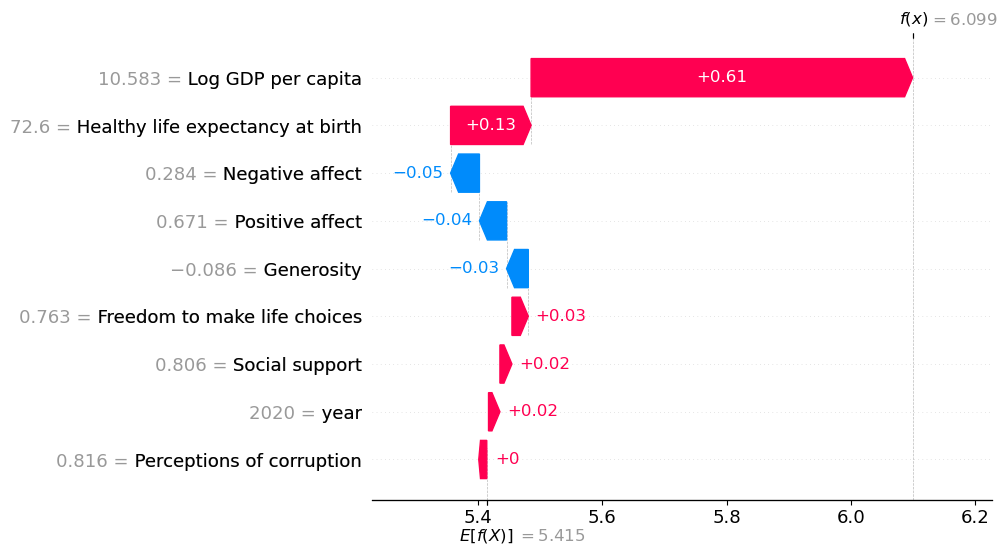

In [41]:
#Summarize the SHAP values for a specific prediction (year 2020) with lightgbm model
shap.plots.waterfall(shap_values_lgbm[100])

### Waterfall LightGBM Regressor shows how each feature contributes to the prediction for one sample. In above sample prediction for sample 100, log gdp per capita has more positive contribution than Perception of corruption. This sample also shows that freedom to make life choices, social support and year has very least contribution towards prediction. Wheras the negative affect , Postive affect and Generosity features are pulling the prediction down.

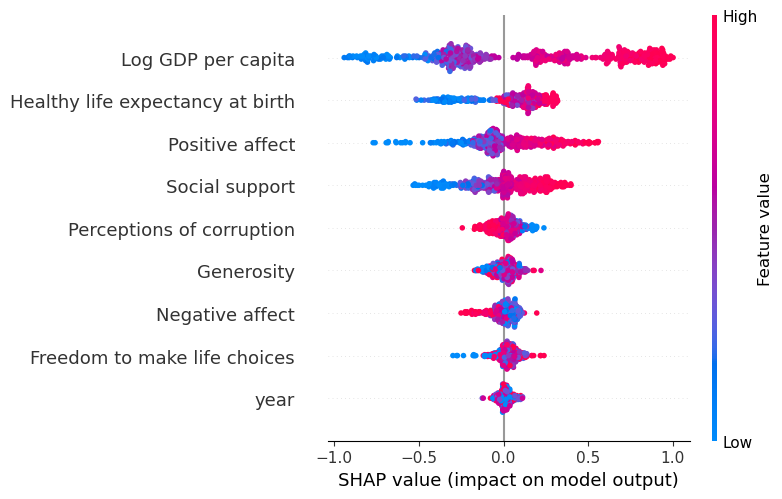

In [42]:
shap.summary_plot(shap_values_lgbm[:500], features_test[:500], show= False)

### Summary plot on LightGBM Regressor gives global overview of feature importance distribution for all samples in whole dataset. This shows the whole dataset.  It can be seen that Log GDP per capita has more data points distribution which is in red. It can be concluded that this feature is moving the prediction to the higher followed by Positive affect and Social support.

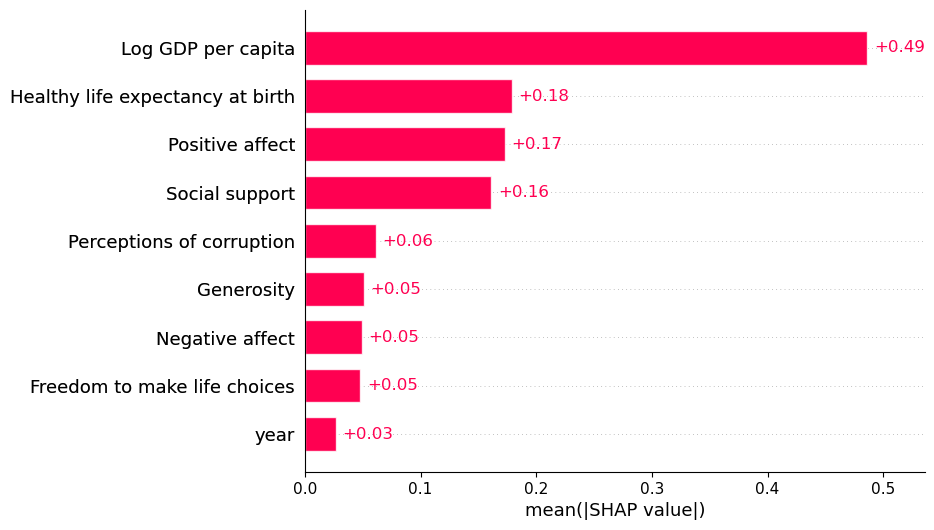

In [43]:
shap.plots.bar(shap_values_lgbm)

### Bar plot on LightGBM Regressor is showing the average absolute SHAP values for each features. Its helps to understand which features are most important in the overall dataset. LightGBM model gave more importance to Log GDP per capita feature by (+0.13) than Catboost model . But on the other hand Light GBM gave less importance to Healthy life expectancy at birth than Catboost model.

In [44]:

model2 = CatBoostRegressor(n_estimators= 190, max_depth= 8).fit(features_train, target_train)

explainer = shap.Explainer(model2, features_train)
shap_values_cbr = explainer(features_test, check_additivity=False)


Learning rate set to 0.172173
0:	learn: 0.9903169	total: 4.3ms	remaining: 813ms
1:	learn: 0.8790332	total: 7.94ms	remaining: 746ms
2:	learn: 0.7876228	total: 11.8ms	remaining: 735ms
3:	learn: 0.7154097	total: 15.2ms	remaining: 708ms
4:	learn: 0.6540750	total: 18.6ms	remaining: 690ms
5:	learn: 0.6068732	total: 21.9ms	remaining: 671ms
6:	learn: 0.5697233	total: 24.8ms	remaining: 648ms
7:	learn: 0.5352018	total: 27.9ms	remaining: 634ms
8:	learn: 0.5106410	total: 30.7ms	remaining: 617ms
9:	learn: 0.4911071	total: 33.8ms	remaining: 609ms
10:	learn: 0.4724149	total: 37.1ms	remaining: 604ms
11:	learn: 0.4561002	total: 39.7ms	remaining: 589ms
12:	learn: 0.4430904	total: 42.6ms	remaining: 580ms
13:	learn: 0.4333684	total: 45.5ms	remaining: 572ms
14:	learn: 0.4252867	total: 48.7ms	remaining: 568ms
15:	learn: 0.4165425	total: 51.7ms	remaining: 563ms
16:	learn: 0.4101592	total: 54.7ms	remaining: 557ms
17:	learn: 0.4037584	total: 57.8ms	remaining: 553ms
18:	learn: 0.3962134	total: 60.6ms	remaining:

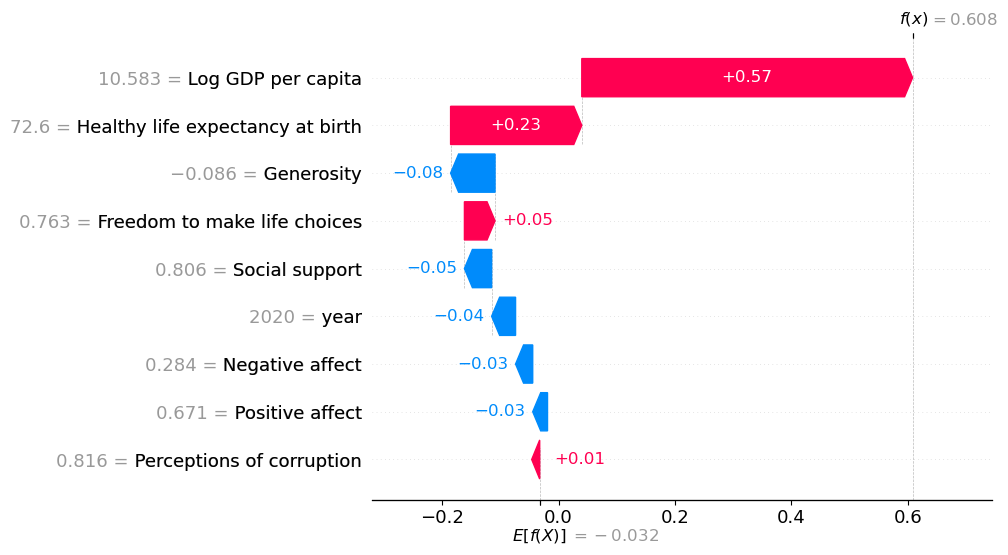

In [45]:
#Summarize the SHAP values for a specific prediction (year 2020) with catboost model
shap.plots.waterfall(shap_values_cbr[100])

### Waterfall CatBoost Regressor shows how each feature contributes to the prediction for one sample. In above sample prediction for sample 100, log gdp per capita has more positive contribution followed by healthy life expectancy at birth.This sample also shows that freedom to make life choices, and Perception of corruption has very least contribution towards prediction. Whereas the Year, Social support, Negative affect , Postive affect and Generosity features are pulling the prediction down.

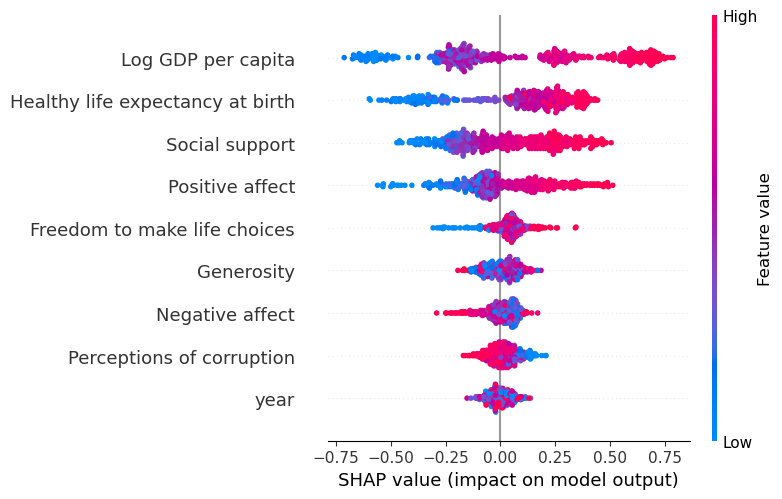

In [46]:
shap.summary_plot(shap_values_cbr[:500], features_test[:500], show= False)

### Summary plot on CatBoost Regressor gives global overview of feature importance distribution for all samples in whole dataset. It can be seen that Log GDP per capita has more data points distribution which is in red. It can be concluded that this feature is moving the prediction to the higher fllowed by Positive affect, Social support, Healthy life expectancy at birth.

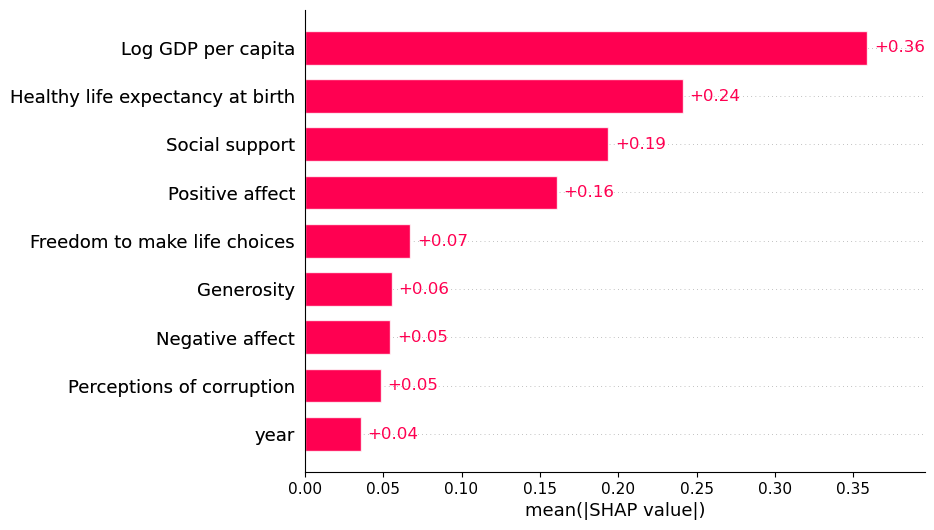

In [47]:
shap.plots.bar(shap_values_cbr)

 ### Bar plot on CatBoost Regressor is showing the average absolute SHAP values for each features in whole dataset.  Its helps to understand which features are most important in the overall dataset. Catboost model gave little bit less importance than Light GBM model to Log GDP per capita feature. But on the other hand Catboost gave more importance to Healthy life expectancy at birth (+0.24) which is more than LightGBM by (+0.6).

## Conclusion on Shap 
 - The social support in the specific sample which was pulled is from year 2020. It was the time when COVID pandemic so that can be the reason why it is pulling prediction down in catboost model(0.05). As thier was less friends and family support as people were cooped up in thier own houses and unable to be in office setting or social setting due to quarantine rules.
- It is also noticed that freedom to life choices has very least positive effect(+0.05) that year on happiness score because the rules got more strict than other years.
- Even during 2020 the birth of healthy babies was increasing happiness score in families as we see positive effect on prediction. So it can be said that this feature did not get much affected in 2020 due to COVID. It could be because both parents were home supporting each other mentally and physically.
